In [85]:
import polars as pl
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm
import upath
import glob
import os 

from dynamic_routing_analysis import decoding_utils

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

## area-wise average decoding accuracy

### old results

In [ ]:
old_loadpath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\logreg_many_n_units_medium_criteria_2025-01-08"
all_decoder_results_path=os.path.join(old_loadpath,'decoder_results_summary.csv')

In [13]:
all_decoder_results=pd.read_csv(all_decoder_results_path)
all_frac_sig_df,all_diff_from_null_df=decoding_utils.compute_significant_decoding_by_area(all_decoder_results)

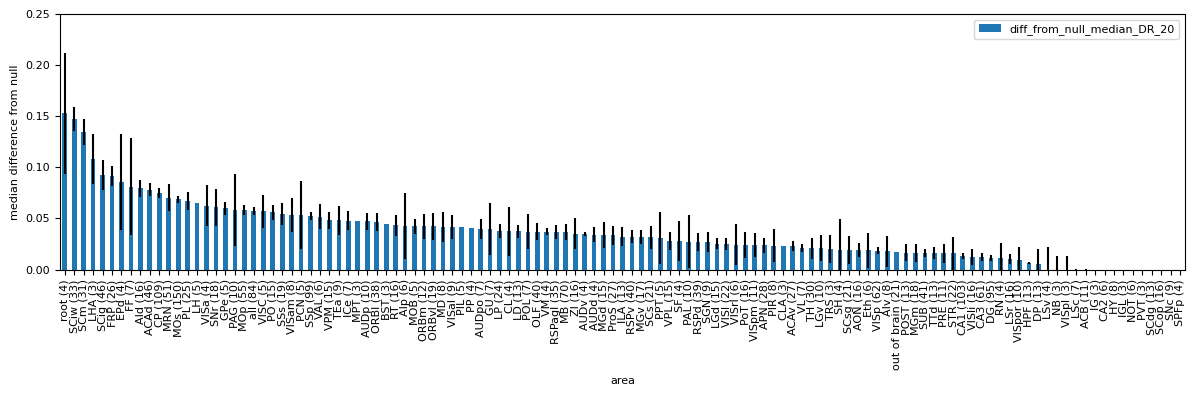

In [22]:
#barplot sorted by DR diff from median
min_n_expts=3
nu='_20'

plot_DR_diff_from_null_df=all_diff_from_null_df.query('n_expts_DR>=@min_n_expts').sort_values('diff_from_null_median_DR'+nu,ascending=False)
fig,ax=plt.subplots(1,1,figsize=(12,4))
plot_DR_diff_from_null_df.plot.bar(x='area',y=['diff_from_null_median_DR'+nu],
                                    yerr='diff_from_null_sem_DR'+nu,ax=ax)

ax.set_ylabel('median difference from null')
area_labels=[]
for i in range(plot_DR_diff_from_null_df.shape[0]):
    area_labels.append(plot_DR_diff_from_null_df['area'].iloc[i]+' ('+str(int(plot_DR_diff_from_null_df['n_expts_DR'].iloc[i]))+')')
ax.set_xticklabels(area_labels,rotation=90,ha='center')

ax.set_ylim([0,0.25])
fig.tight_layout()



### new results

In [25]:
new_results_path=upath.UPath("s3://aind-scratch-data/dynamic-routing/decoding/results/validate_v260_20250401_030903/")

In [29]:
#select DR production experiments with good behavior

session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\new_decoder_run_2025-03-31\session_table_v0.260.csv"
session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project').eq('DynamicRouting'),
    pl.col('is_production').eq(True),
    pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )
# dr_session_list

In [30]:
#define grouping columns
grouping_cols = {
    'session_id',
    'structure',
    'electrode_group_names',
    'min_n_units',
    'unit_criteria',
}

#toggle combine_multi_probe_rec
combine_multi_probe_rec = True

if combine_multi_probe_rec:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().gt(1) | pl.col('is_sole_recording').eq(True)
else:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().eq(1) | pl.col('is_sole_recording').eq(True)


In [153]:
new_results_df = (
    pl.scan_parquet(new_results_path)
    .with_columns(
        pl.col('electrode_group_names').list.n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),
    )
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials').not_(),
        pl.col('session_id').is_in(dr_session_list),
        ###is this different from what I did before? do we need to filter again after to really get >=3 sessions?
        pl.col('session_id').n_unique().ge(3).over('structure', 'min_n_units', 'unit_criteria'),
    )
    # get the means for each recording over their shifts:
    .group_by(grouping_cols | {'repeat_idx'})
    .agg(
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0)).mean().alias('mean_true'),
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0).not_()).median().alias('median_null'),
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0)).mean().sub(
            pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0).not_()).median()
        ).alias('mean_diff')
    )
    # get the means over repeats:
    .group_by(grouping_cols)
    .agg(
        pl.col('mean_true').mean(),
        pl.col('median_null').mean(),
        pl.col('mean_diff').mean()
    )   
    # get the means over sessions:
    .group_by('structure', 'min_n_units', 'unit_criteria')
    .agg(
        pl.col('mean_true').mean(),
        pl.col('median_null').mean(),
        pl.col('mean_diff').mean(),
        pl.col('mean_true').std().truediv(pl.col('mean_true').count().pow(0.5)).alias('sem_diff')
    )
    .sort(pl.col('mean_diff').mean().over('structure'), descending=True)
    .collect(streaming=True)
)

In [156]:
new_results_df

structure,min_n_units,unit_criteria,mean_true,median_null,mean_diff,sem_diff
str,u8,cat,f64,f64,f64,f64
"""SCiw""",20,"""medium""",0.799538,0.650441,0.149097,0.020003
"""FF""",20,"""medium""",0.733724,0.599349,0.134375,null
"""SCm""",20,"""medium""",0.766981,0.637529,0.129452,0.013478
"""SCig""",20,"""medium""",0.733073,0.618779,0.114293,0.026013
"""SNr""",20,"""medium""",0.718271,0.609213,0.109058,0.052777
…,…,…,…,…,…,…
"""TTd""",20,"""medium""",0.550042,0.549854,0.000188,0.019576
"""RN""",20,"""medium""",0.540709,0.547324,-0.006615,null
"""ACB""",20,"""medium""",0.55382,0.562772,-0.008952,0.008567


In [51]:
df_all_good_sessions = (
    pl.scan_parquet(new_results_path)
    .with_columns(
        pl.col('electrode_group_names').list.n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),
    )
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials').not_(),
        pl.col('session_id').is_in(dr_session_list),
        pl.col('session_id').n_unique().ge(3).over('structure', 'min_n_units', 'unit_criteria'),
    )
    # get the means for each recording over their shifts:
    .group_by(grouping_cols | {'repeat_idx'})
    .agg(
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0)).mean().alias('mean_true'),
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0).not_()).median().alias('median_null'),
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0)).mean().sub(
            pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0).not_()).median()
        ).alias('mean_diff')
    )
    # get the means over repeats:
    .group_by(grouping_cols)
    .agg(
        pl.col('mean_true').mean(),
        pl.col('median_null').mean(),
        pl.col('mean_diff').mean()
    )   
    .sort(pl.col('session_id'), descending=True)
    .collect(streaming=True)
)

In [52]:
#calculate means and sem manually for each area

df_all_good_sessions=df_all_good_sessions.to_pandas()
df_all_good_sessions

,structure,min_n_units,unit_criteria,electrode_group_names,session_id,mean_true,median_null,mean_diff
0,CP,20,medium,[probeA],742903_2024-10-24,0.561859,0.545263,0.016596
1,CA1,20,medium,[probeE],742903_2024-10-24,0.527515,0.524685,0.002830
2,VISal,20,medium,[probeC],742903_2024-10-24,0.522463,0.510485,0.011978
3,CA1,20,medium,"[probeE, probeC]",742903_2024-10-24,0.542945,0.529721,0.013224
4,SSp,20,medium,[probeA],742903_2024-10-24,0.546465,0.545699,0.000766
...,...,...,...,...,...,...,...,...
1236,DG,20,medium,[probeB],626791_2022-08-15,0.648260,0.606874,0.041386
1237,LP,20,medium,[probeA],626791_2022-08-15,0.629038,0.575818,0.053220
1238,LGd,20,medium,[probeB],626791_2022-08-15,0.596193,0.567795,0.028398
1239,PO,20,medium,[probeA],626791_2022-08-15,0.647780,0.585210,0.062570


In [55]:
new_results_by_area_df={
    'structure':[],
    'mean_diff':[],
    'sem_diff':[],
    'n_sessions':[],
}

for area in df_all_good_sessions['structure'].unique():
    area_df=df_all_good_sessions.query('structure==@area')
    mean_diff=area_df['mean_diff'].mean()
    sem_diff=area_df['mean_diff'].sem()

    new_results_by_area_df['structure'].append(area)
    new_results_by_area_df['mean_diff'].append(mean_diff)
    new_results_by_area_df['sem_diff'].append(sem_diff)
    new_results_by_area_df['n_sessions'].append(area_df.shape[0])

new_results_by_area_df=pd.DataFrame(new_results_by_area_df)

In [56]:
new_results_by_area_df

,structure,mean_diff,sem_diff,n_sessions
0,CP,0.077018,0.005370,76
1,CA1,0.018158,0.003064,69
2,VISal,0.043096,0.010326,6
3,SSp,0.056139,0.003842,85
4,SSs,0.060088,0.011356,15
...,...,...,...,...
91,VPM,0.041187,0.008439,10
92,PIR,0.048606,0.023600,3
93,EPd,0.079194,NaN,1
94,VISa,0.067326,0.003681,2


<Axes: xlabel='structure'>

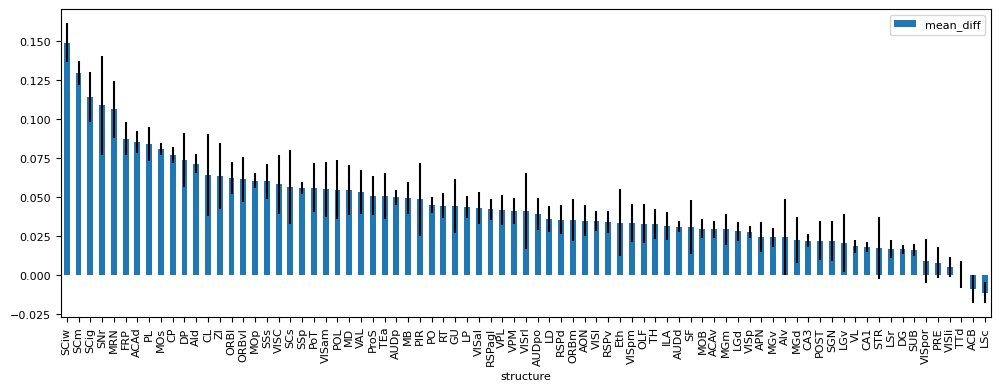

In [60]:
fig,ax=plt.subplots(1,1,figsize=(12,4))
new_results_by_area_df.query('n_sessions>=3').sort_values(by='mean_diff',ascending=False).plot.bar(ax=ax,x='structure',y=['mean_diff'],yerr='sem_diff',rot=90)

In [63]:
#merge new and old results
old=plot_DR_diff_from_null_df[['area','diff_from_null_median_DR_20','diff_from_null_sem_DR_20','n_expts_DR']]
new=new_results_by_area_df.query('n_sessions>=3')

merged=pd.merge(left=old,right=new,left_on='area',right_on='structure',suffixes=('_old','_new'))
merged

,area,diff_from_null_median_DR_20,diff_from_null_sem_DR_20,n_expts_DR,structure,mean_diff,sem_diff,n_sessions
0,SCiw,0.146947,0.011836,33.0,SCiw,0.149097,0.012347,15
1,SCm,0.134627,0.013022,31.0,SCm,0.129452,0.007786,30
2,SCig,0.092493,0.014396,46.0,SCig,0.114293,0.015780,12
3,FRP,0.091359,0.009996,26.0,FRP,0.087529,0.010510,12
4,AId,0.079400,0.008646,16.0,AId,0.071540,0.005989,10
...,...,...,...,...,...,...,...,...
74,LSr,0.010459,0.005149,16.0,LSr,0.016708,0.005931,11
75,VISpor,0.009682,0.012529,10.0,VISpor,0.009052,0.013864,8
76,DP,0.005900,0.014100,13.0,DP,0.073781,0.017295,3
77,LSc,-0.007360,0.007496,7.0,LSc,-0.011258,0.006958,4


In [ ]:
# .filter(
#     combine_multi_probe_expr,
#     pl.col('is_all_trials').not_(),
#     pl.col('session_id').is_in(dr_session_list),
#     pl.col('session_id').n_unique().ge(3).over('structure', 'min_n_units', 'unit_criteria'),
# )

Text(0.5, 1.0, 'compare old vs. new decoding methods')

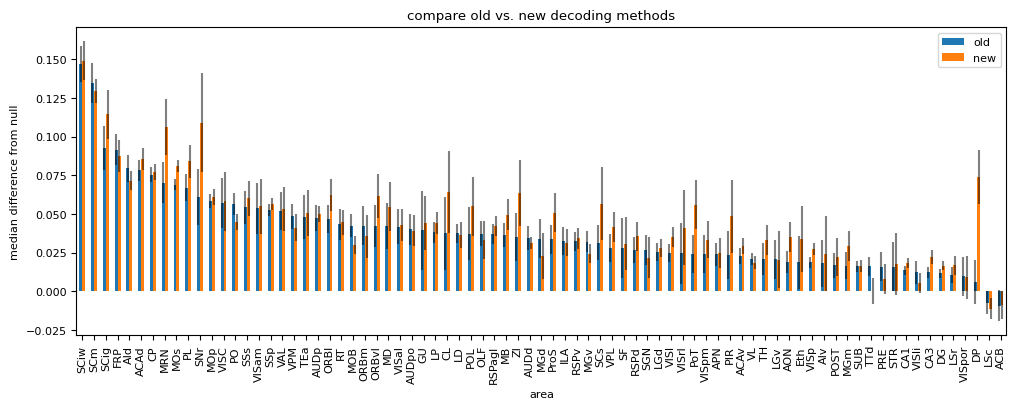

In [76]:
fig,ax=plt.subplots(1,1,figsize=(12,4))
merged.plot.bar(x='area',y=['diff_from_null_median_DR_20','mean_diff'],ax=ax)
ax.errorbar(x=np.arange(len(merged))-0.15,y=merged['diff_from_null_median_DR_20'],yerr=merged['diff_from_null_sem_DR_20'],linestyle='None',color='k',alpha=0.5)
ax.errorbar(x=np.arange(len(merged))+0.15,y=merged['mean_diff'],yerr=merged['sem_diff'],linestyle='None',color='k',alpha=0.5)
ax.set_ylabel('median difference from null')
ax.legend(['old','new'])
ax.set_title('compare old vs. new decoding methods')

Text(0.5, 1.0, 'pearson r=0.887, p=1.263e-27')

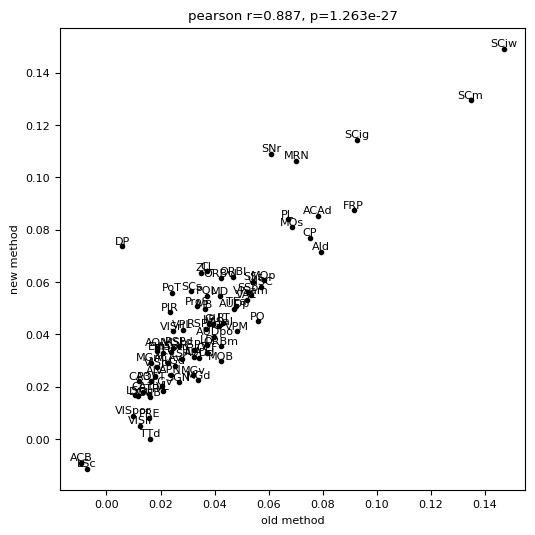

In [94]:
#get pearson correlation
r,p=stats.pearsonr(merged['diff_from_null_median_DR_20'],merged['mean_diff'])

fig,ax=plt.subplots(1,1,figsize=(6,6))
ax.scatter(merged['diff_from_null_median_DR_20'],merged['mean_diff'],marker='.',color='k')
#plot name of area above each point
for i in range(merged.shape[0]):
    ax.text(merged['diff_from_null_median_DR_20'].iloc[i],merged['mean_diff'].iloc[i],merged['area'].iloc[i],fontsize=8,ha='center',va='bottom')
ax.set_xlabel('old method')
ax.set_ylabel('new method')
ax.set_title('pearson r='+str(np.round(r,decimals=3))+', p='+str(format(p,'.3e')))

## session-by-session correlation

In [100]:
df_all_sessions = (
    pl.scan_parquet(new_results_path)
    .with_columns(
        pl.col('electrode_group_names').list.n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),
    )
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials').not_(),
        pl.col('session_id').n_unique().ge(3).over('structure', 'min_n_units', 'unit_criteria'),
    )
    # get the means for each recording over their shifts:
    .group_by(grouping_cols | {'repeat_idx'})
    .agg(
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0)).mean().alias('mean_true'),
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0).not_()).median().alias('median_null'),
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0)).mean().sub(
            pl.col('balanced_accuracy_test').filter(pl.col('shift_idx').eq(0).not_()).median()
        ).alias('mean_diff')
    )
    # get the means over repeats:
    .group_by(grouping_cols)
    .agg(
        pl.col('mean_true').mean(),
        pl.col('median_null').mean(),
        pl.col('mean_diff').mean()
    )   
    .sort(pl.col('session_id'), descending=True)
    .collect(streaming=True)
)
df_all_sessions

structure,min_n_units,unit_criteria,electrode_group_names,session_id,mean_true,median_null,mean_diff
str,u8,cat,list[str],str,f64,f64,f64
"""SSp""",20,"""medium""","[""probeB""]","""742903_2024-10-24""",0.546515,0.546453,0.000063
"""PoT""",20,"""medium""","[""probeE""]","""742903_2024-10-24""",0.524042,0.520824,0.003218
"""MGm""",20,"""medium""","[""probeE""]","""742903_2024-10-24""",0.532867,0.532451,0.000416
"""VISal""",20,"""medium""","[""probeC""]","""742903_2024-10-24""",0.522463,0.510485,0.011978
"""SSs""",20,"""medium""","[""probeB""]","""742903_2024-10-24""",0.583574,0.552644,0.030929
…,…,…,…,…,…,…,…
"""ACAv""",20,"""medium""","[""probeF""]","""620263_2022-07-26""",0.570316,0.557018,0.013298
"""MOs""",20,"""medium""","[""probeF""]","""620263_2022-07-26""",0.567207,0.568371,-0.001163
"""CA1""",20,"""medium""","[""probeB""]","""620263_2022-07-26""",0.563351,0.545846,0.017505


In [105]:
# df_all_sessions = df_all_sessions.to_pandas()
df_all_sessions

,structure,min_n_units,unit_criteria,electrode_group_names,session_id,mean_true,median_null,mean_diff
0,SSp,20,medium,[probeB],742903_2024-10-24,0.546515,0.546453,0.000063
1,PoT,20,medium,[probeE],742903_2024-10-24,0.524042,0.520824,0.003218
2,MGm,20,medium,[probeE],742903_2024-10-24,0.532867,0.532451,0.000416
3,VISal,20,medium,[probeC],742903_2024-10-24,0.522463,0.510485,0.011978
4,SSs,20,medium,[probeB],742903_2024-10-24,0.583574,0.552644,0.030929
...,...,...,...,...,...,...,...,...
2487,ACAv,20,medium,[probeF],620263_2022-07-26,0.570316,0.557018,0.013298
2488,MOs,20,medium,[probeF],620263_2022-07-26,0.567207,0.568371,-0.001163
2489,CA1,20,medium,[probeB],620263_2022-07-26,0.563351,0.545846,0.017505
2490,ACAd,20,medium,[probeF],620263_2022-07-26,0.574755,0.579985,-0.005230


In [114]:
all_decoder_results.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'session_id', 'project', 'area',
       'ccf_ap_mean', 'ccf_dv_mean', 'ccf_ml_mean', 'n_units', 'probe',
       'cross_modal_dprime', 'n_good_blocks', 'true_accuracy_10',
       'null_accuracy_mean_10', 'null_accuracy_median_10',
       'null_accuracy_std_10', 'p_value_10',
       'true_accuracy_all_trials_no_shift_10', 'true_accuracy_20',
       'null_accuracy_mean_20', 'null_accuracy_median_20',
       'null_accuracy_std_20', 'p_value_20',
       'true_accuracy_all_trials_no_shift_20', 'true_accuracy_30',
       'null_accuracy_mean_30', 'null_accuracy_median_30',
       'null_accuracy_std_30', 'p_value_30',
       'true_accuracy_all_trials_no_shift_30', 'true_accuracy_40',
       'null_accuracy_mean_40', 'null_accuracy_median_40',
       'null_accuracy_std_40', 'p_value_40',
       'true_accuracy_all_trials_no_shift_40', 'true_accuracy_all',
       'null_accuracy_mean_all', 'null_accuracy_median_all',
       'null_accuracy_std_all', 'p_value_all',

In [115]:
all_decoder_results['mean_diff']=all_decoder_results['true_accuracy_20']-all_decoder_results['null_accuracy_median_20']
old_decoder_results=all_decoder_results.query('probe=="all" or probe.isna()')[['area','session_id','project','mean_diff','true_accuracy_20','null_accuracy_median_20','n_units']]
old_decoder_results

,area,session_id,project,mean_diff,true_accuracy_20,null_accuracy_median_20,n_units
0,DG,620263_2022-07-26,TempletonPilotSession,0.001713,0.540771,0.539057,83
2,VISp,620263_2022-07-26,TempletonPilotSession,-0.004562,0.511391,0.515953,116
4,TEa,620263_2022-07-26,TempletonPilotSession,-0.011509,0.540262,0.551771,69
5,VISli,620263_2022-07-26,TempletonPilotSession,0.000279,0.519274,0.518995,105
6,VISl,620263_2022-07-26,TempletonPilotSession,0.011907,0.540007,0.528100,23
...,...,...,...,...,...,...,...
3815,MOp,742903_2024-10-24,DynamicRouting,0.010889,0.543711,0.532822,142
3816,all,742903_2024-10-24,DynamicRouting,0.015817,0.554715,0.538898,1365
3817,CA1,742903_2024-10-24,DynamicRouting,0.013949,0.541347,0.527398,48
3818,CP,742903_2024-10-24,DynamicRouting,0.043241,0.575184,0.531942,321


In [116]:
#merge old and new results on area and session_id

old_decoder_results['session_id']=old_decoder_results['session_id'].astype(str)
merged_all_sessions=pd.merge(left=df_all_sessions,right=old_decoder_results,left_on=['structure','session_id'],right_on=['area','session_id'],suffixes=('_new','_old'))
merged_all_sessions

,structure,min_n_units,unit_criteria,electrode_group_names,session_id,mean_true,median_null,mean_diff_new,area,project,mean_diff_old,true_accuracy_20,null_accuracy_median_20,n_units
0,SSp,20,medium,[probeB],742903_2024-10-24,0.546515,0.546453,0.000063,SSp,DynamicRouting,0.023013,0.567248,0.544235,296
1,PoT,20,medium,[probeE],742903_2024-10-24,0.524042,0.520824,0.003218,PoT,DynamicRouting,0.000082,0.522495,0.522413,87
2,MGm,20,medium,[probeE],742903_2024-10-24,0.532867,0.532451,0.000416,MGm,DynamicRouting,-0.008835,0.522982,0.531817,45
3,VISal,20,medium,[probeC],742903_2024-10-24,0.522463,0.510485,0.011978,VISal,DynamicRouting,0.016436,0.528230,0.511794,40
4,SSs,20,medium,[probeB],742903_2024-10-24,0.583574,0.552644,0.030929,SSs,DynamicRouting,0.022132,0.571962,0.549829,116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2453,ACAv,20,medium,[probeF],620263_2022-07-26,0.570316,0.557018,0.013298,ACAv,TempletonPilotSession,0.006942,0.565685,0.558743,138
2454,MOs,20,medium,[probeF],620263_2022-07-26,0.567207,0.568371,-0.001163,MOs,TempletonPilotSession,0.001473,0.570179,0.568706,64
2455,CA1,20,medium,[probeB],620263_2022-07-26,0.563351,0.545846,0.017505,CA1,TempletonPilotSession,0.006585,0.570842,0.564257,213
2456,ACAd,20,medium,[probeF],620263_2022-07-26,0.574755,0.579985,-0.005230,ACAd,TempletonPilotSession,0.002906,0.586087,0.583181,53


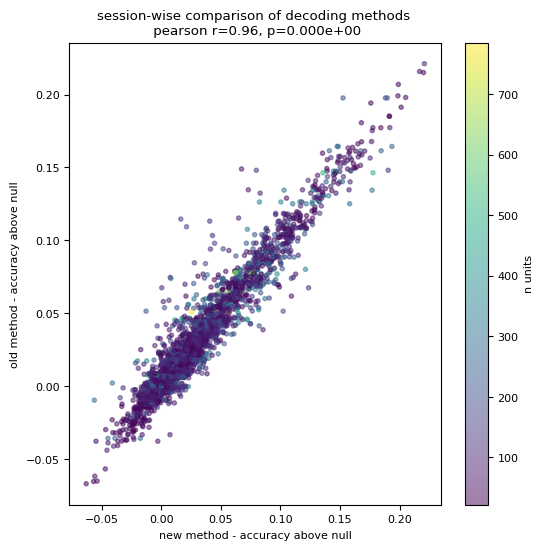

In [137]:
r,p=stats.pearsonr(merged_all_sessions.query('~mean_diff_new.isna() and ~mean_diff_old.isna()')['mean_diff_new'],
                   merged_all_sessions.query('~mean_diff_new.isna() and ~mean_diff_old.isna()')['mean_diff_old'])

fig,ax=plt.subplots(1,1,figsize=(6,6))
# ax.scatter(merged_all_sessions['mean_diff_new'],merged_all_sessions['mean_diff_old'],marker='.',color='k')
points=ax.scatter(merged_all_sessions['mean_diff_new'],merged_all_sessions['mean_diff_old'],marker='.',
                  c=merged_all_sessions['n_units'],alpha=0.5,cmap='viridis')
ax.set_xlabel('new method - accuracy above null')
ax.set_ylabel('old method - accuracy above null')
ax.set_title('session-wise comparison of decoding methods \n pearson r='+str(np.round(r,decimals=3))+', p='+str(format(p,'.3e')))
fig.colorbar(label='n units',mappable=points,)


Text(0.5, 1.0, 'n_units <= 30 \n pearson r=0.99, p=1.160e-205')

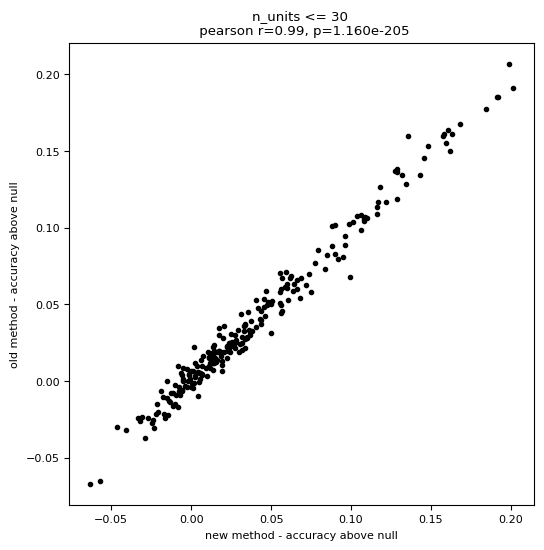

In [136]:
max_n_units=30
filter_n_units=merged_all_sessions.query('n_units<=@max_n_units')

r,p=stats.pearsonr(filter_n_units.query('~mean_diff_new.isna() and ~mean_diff_old.isna()')['mean_diff_new'],
                   filter_n_units.query('~mean_diff_new.isna() and ~mean_diff_old.isna()')['mean_diff_old'])

fig,ax=plt.subplots(1,1,figsize=(6,6))
ax.scatter(filter_n_units['mean_diff_new'],filter_n_units['mean_diff_old'],marker='.',color='k')
ax.set_xlabel('new method - accuracy above null')
ax.set_ylabel('old method - accuracy above null')
ax.set_title('n_units <= '+str(max_n_units)+' \n pearson r='+str(np.round(r,decimals=3))+', p='+str(format(p,'.3e')))


In [150]:
n_units_range=np.arange(20,350,20)

n_units_r_list=[]
n_units_p_list=[]

for n_units in n_units_range:
    min_n_units=n_units-10
    max_n_units=n_units+10
    filter_n_units=merged_all_sessions.query('n_units>@min_n_units and n_units<=@max_n_units')
    if len(filter_n_units)<2:
        n_units_r_list.append(np.nan)
        n_units_p_list.append(np.nan)
        continue
    r,p=stats.pearsonr(filter_n_units.query('~mean_diff_new.isna() and ~mean_diff_old.isna()')['mean_diff_new'],
                   filter_n_units.query('~mean_diff_new.isna() and ~mean_diff_old.isna()')['mean_diff_old'])
    n_units_r_list.append(r)
    n_units_p_list.append(p)

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_7248\2508427145.py:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r,p=stats.pearsonr(filter_n_units.query('~mean_diff_new.isna() and ~mean_diff_old.isna()')['mean_diff_new'],


Text(0, 0.5, 'pearson r')

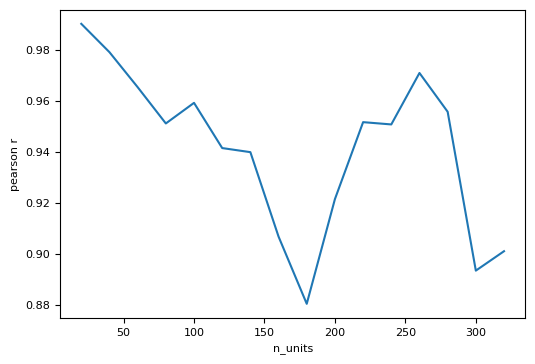

In [152]:
fig,ax=plt.subplots(1,1,figsize=(6,4))
ax.plot(n_units_range,n_units_r_list)
ax.set_xlabel('n_units')
ax.set_ylabel('pearson r')

# n_units_r_list

In [140]:
filter_n_units

,structure,min_n_units,unit_criteria,electrode_group_names,session_id,mean_true,median_null,mean_diff_new,area,project,mean_diff_old,true_accuracy_20,null_accuracy_median_20,n_units


Text(0.5, 1.0, 'session-wise comparison of decoding methods \n pearson r=0.972, p=0.000e+00')

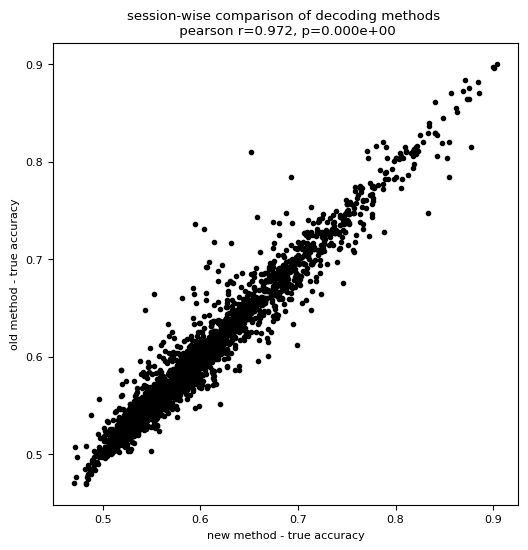

In [ ]:
r,p=stats.pearsonr(merged_all_sessions.query('~mean_true.isna() and ~true_accuracy_20.isna()')['mean_true'],
                   merged_all_sessions.query('~mean_true.isna() and ~true_accuracy_20.isna()')['true_accuracy_20'])

fig,ax=plt.subplots(1,1,figsize=(6,6))
ax.scatter(merged_all_sessions['mean_true'],merged_all_sessions['true_accuracy_20'],marker='.',color='k')
ax.set_xlabel('new method - true accuracy')
ax.set_ylabel('old method - true accuracy')
ax.set_title('session-wise comparison of decoding methods \n pearson r='+str(np.round(r,decimals=3))+', p='+str(format(p,'.3e')))


Text(0.5, 1.0, 'session-wise comparison of decoding methods \n pearson r=0.963, p=0.000e+00')

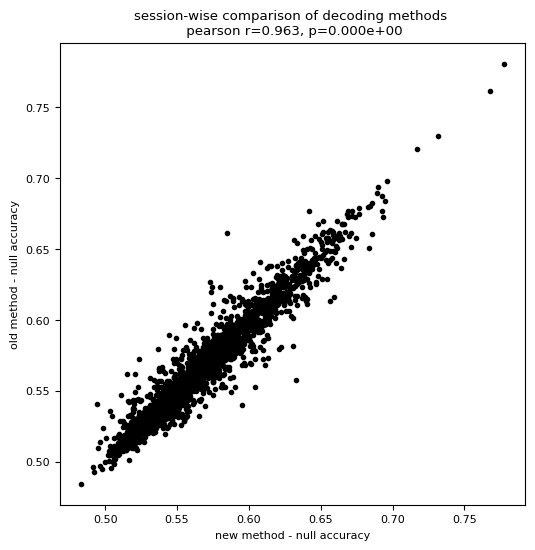

In [113]:
r,p=stats.pearsonr(merged_all_sessions.query('~median_null.isna() and ~null_accuracy_median_20.isna()')['median_null'],
                   merged_all_sessions.query('~median_null.isna() and ~null_accuracy_median_20.isna()')['null_accuracy_median_20'])

fig,ax=plt.subplots(1,1,figsize=(6,6))
ax.scatter(merged_all_sessions['median_null'],merged_all_sessions['null_accuracy_median_20'],marker='.',color='k')
ax.set_xlabel('new method - null accuracy')
ax.set_ylabel('old method - null accuracy')
ax.set_title('session-wise comparison of decoding methods \n pearson r='+str(np.round(r,decimals=3))+', p='+str(format(p,'.3e')))


## trialwise correlation

correlations should be high between areas in the same session, even across different decoder runs

In [159]:
old_trialwise_results_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\logreg_many_n_units_medium_criteria_2025-01-08\decoder_confidence_all_trials_20_units.pkl"

In [163]:
old_trialwise_results=pd.read_pickle(old_trialwise_results_path)
# old_trialwise_results

In [162]:
old_trialwise_results.query('probe=="all" or probe==""')

,session,area,project,probe,cross_modal_dprime,n_good_blocks,trial_index,confidence,predict_proba,ccf_ap_mean,ccf_dv_mean,ccf_ml_mean,n_units
0,620263_2022-07-26,DG,TempletonPilotSession,,NaN,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.633973551020234, 0.1897283509118274, 0.5583...","[0.598842891868319, 0.5214440346869513, 0.5768...",8310.542169,2863.253012,3189.759036,83
2,620263_2022-07-26,VISp,TempletonPilotSession,,NaN,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0718289188854475, 1.3397289381630912, 0.739...","[0.7069663181522203, 0.6903215523241844, 0.646...",8379.956897,1102.370690,3442.456897,116
4,620263_2022-07-26,TEa,TempletonPilotSession,,NaN,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.9152233240747419, 0.7419807793278537, 1.302...","[0.6683237038454021, 0.6423792180255531, 0.764...",8640.217391,2378.260870,1814.492754,69
5,620263_2022-07-26,VISli,TempletonPilotSession,,NaN,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.27475744930430834, 0.9383534689160402, 0.13...","[0.550840455903579, 0.6927075865634648, 0.5129...",8735.000000,2007.142857,1807.380952,105
6,620263_2022-07-26,VISl,TempletonPilotSession,,NaN,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.4644200607591052, 0.8164489928163522, 0.415...","[0.6030135507231368, 0.6541357485582718, 0.608...",8803.260870,1782.608696,1771.739130,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,742903_2024-10-24,MOp,DynamicRouting,,2.339739,5,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-0.14579500653781602, -0.3358121577512655, -0...","[0.4786210976389054, 0.4183672811744888, 0.329...",4101.056338,2594.014085,3239.084507,142
16,742903_2024-10-24,all,DynamicRouting,,2.339739,5,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-1.220148078728816, -1.713272540241461, -1.88...","[0.30197712681691136, 0.23911392657725666, 0.2...",6452.969208,3147.140762,2822.452346,1365
17,742903_2024-10-24,CA1,DynamicRouting,all,2.339739,5,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-2.7676298934815686, -3.1577544236939947, -2....","[0.11693431648689862, 0.13171468343517556, 0.1...",7710.416667,2355.208333,2661.458333,48
18,742903_2024-10-24,CP,DynamicRouting,all,2.339739,5,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-0.11377123324703266, -1.1734378721406766, -1...","[0.5159826789392902, 0.31359777422240637, 0.26...",5323.052960,4030.841121,3302.414330,321
